In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import datetime
import scipy
from src.config import configurations
from src.dimensionality_reduction import compute_covariance, visualize_manifold_method, choose_dimension
from src.utils import define_paths, load_data, convert_to_python_dict, save_obj, load_obj, find_closest_time_series
from src.utils import plot_time_series
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from sklearn.manifold import Isomap, SpectralEmbedding, LocallyLinearEmbedding, trustworthiness
from sklearn.manifold import trustworthiness
from copy import copy 
from kneed import DataGenerator, KneeLocator
import pickle
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams['figure.dpi'] = 600

/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior


In [2]:
configurations

{'clustering_palette': ['#1f78b4', '#a6cee3', '#fdbf6f', '#ff7f00', '#cc78bc'],
 'WASHINGTON_SHAPE_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/wa_shape/cb_2019_53_bg_500k.shp',
 'TEXAS_SHAPE_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/tx_shape/cb_2019_48_bg_500k.shp',
 'GEORGIA_SHAPE_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/ga_shape/cb_2019_13_bg_500k.shp',
 'CALIFORNIA_SHAPE_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/ca_shape/cb_2019_06_bg_500k.shp',
 'wa_PLACES_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/wa_places/cb_2019_53_place_500k.shp',
 'tx_PLACES_PATH': '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/tx_places/cb_2019_48_place_500k.shp',
 'ga_PLACES_PATH': '/mnt/c/Users/rlevin/Docume

In [3]:
#  print(os.path.abspath(os.path.join(os.getcwd(), '..', 'reports')))

In [4]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')
# utils.install_packages('mclust')

In [5]:
STATE = 'wa'

# #Shape files:
# WASHINGTON_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'external', 'washington_blockgroup_shape', 'tl_2015_53_bg', 'tl_2015_53_bg.shp'))
# TEXAS_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external','texas_blockgroup_shape','tl_2016_48_bg','tl_2016_48_bg.shp'))
# GEORGIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'georgia_blockgroup_shape','tl_2017_13_bg.shp'))
# CALIFORNIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'california_blockgroup_shape','tl_2016_06_bg.shp'))

# #Figures:
# WASHINGTON_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'WA'))
# TEXAS_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'TX'))
# GEORGIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'GA'))
# CALIFORNIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'CA'))

# #Data:
# DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
# WASHINGTON_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-washington.csv'))
# GEORGIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-georgia.csv'))
# TEXAS_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-texas.csv'))
# CALIFORNIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-california.csv'))

# def define_paths(STATE):
#     if STATE == 'wa':
#         SHAPE_PATH = configurations['WASHINGTON_SHAPE_PATH']
#         FIGURE_PATH = configurations['WASHINGTON_FIGURE_PATH']
#         RAW_DATA_PATH = configurations['WASHINGTON_RAW_DATA_PATH']
#     if STATE == 'tx':
#         SHAPE_PATH = configurations['TEXAS_SHAPE_PATH']
#         FIGURE_PATH = configurations['TEXAS_FIGURE_PATH']
#         RAW_DATA_PATH = configurations['TEXAS_RAW_DATA_PATH']
#     if STATE == 'ga':
#         SHAPE_PATH = configurations['GEORGIA_SHAPE_PATH']
#         FIGURE_PATH = configurations['GEORGIA_FIGURE_PATH']
#         RAW_DATA_PATH = configurations['GEORGIA_RAW_DATA_PATH']
#     if STATE == 'ca':
#         SHAPE_PATH = configurations['CALIFORNIA_SHAPE_PATH']
#         FIGURE_PATH = configurations['CALIFORNIA_FIGURE_PATH']
#         RAW_DATA_PATH = configurations['CALIFORNIA_RAW_DATA_PATH']
#     return SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH

# SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH = define_paths(STATE)
# SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH

In [6]:
define_paths('wa')

('/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/wa_shape/cb_2019_53_bg_500k.shp',
 '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/reports/figures/WA',
 '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/raw/stayathome-washington.csv',
 '/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior/data/external/income_population')

In [7]:
# #Load the data
# def load_data(RAW_DATA_PATH):
#     covid = pd.read_csv(RAW_DATA_PATH)
#     covid_ = covid.set_index('Unnamed: 0')
#     covid_ = covid_[covid_.columns[:117]] #to consider the same time period with our WA analysis
#     #Prepare the data: drop nans
#     X = covid_.dropna().values
#     index_X = covid_.dropna().index
#     columns_X = covid_.dropna().columns
#     print('Data loaded:', X.shape, covid_.shape)
#     return covid_, X, index_X, columns_X


In [8]:
#Define functions
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import Isomap

# def convert_to_python_dict(mc):
#     return dict(zip(mc.names, list(mc)))

# def save_obj(obj, name ):
#     with open(os.path.join('obj', name + '.pkl'), 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# def load_obj(name ):
#     with open(os.path.join('obj', name + '.pkl'), 'rb') as f:
#         return pickle.load(f)
    
# def find_closest_time_series(SE_behavior, SE_means, covid_, index_X, n = 5):
#     """Finds n closest time series to the cluster means (or the vectors in SE_means)
#     returns dict with keys V1...V6 cluster names and values dataframes with the n closest samples
#     same for block_ids    
#     """
#     #ADD index_X here!!!
#     closest_to_mean_samples = {}
#     closest_to_mean_block_ids = {}
#     for cluster in SE_means.columns:
#         sorted_indices = np.squeeze(np.argsort(scipy.spatial.distance.cdist(SE_behavior, SE_means[cluster][None,:], metric='euclidean'), axis = 0))
#         closest_to_mean_samples[cluster] = covid_.loc[index_X[sorted_indices[:n]]] #Take the closest n points
#         closest_to_mean_block_ids[cluster] = index_X[sorted_indices[:n]]
#     return closest_to_mean_samples, closest_to_mean_block_ids


# def plot_time_series(time_series_df, name = 'time_series_of_interest', filename = None, only_melt = False):
# #     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
#     time_series_df_ = time_series_df.copy().T
#     time_series_df_['dates'] = pd.to_datetime(time_series_df.columns)
#     #closest_to_mean_sample_ = closest_to_mean_sample.T
#     #closest_to_mean_sample_['dates'] = pd.to_datetime(columns_X)
# #     closest_to_mean_sample_
#     #Cluster means figure
#     sns.set(style="darkgrid")
# #     sns.set_palette("tab10")
#     melted_df = pd.melt(time_series_df_,
#                         id_vars=['dates'], # Variables to keep
#                         var_name="Block")
#     if only_melt:
#         return melted_df
#     g = sns.relplot(x = 'dates', y="value", row = 'Block', 
#                     kind="line", row_order=time_series_df.index, data=melted_df, sort = False, aspect = 5, marker='o')
#     g.fig.autofmt_xdate(0,10)
#     plt.subplots_adjust(top=0.93)
#     g.fig.suptitle(name, size = 'xx-large')
#     g.set(ylim=(0, 1))


#     #Add the important dates
#     # ax = g.axes[1]

#     for axs in g.axes:
#         axs[0].axvline(datetime(2020, 2, 29), color = 'green', ls='--', label='emergency_WA')
#         axs[0].axvline(datetime(2020, 3, 3), color = 'blue', ls='--', label='emergency_Seattle')
#         axs[0].axvline(datetime(2020, 3, 11), color = 'red', ls='--', label='events_ban')
#         axs[0].axvline(datetime(2020, 3, 12), color = 'brown', ls='--', label='schools')
#         axs[0].axvline(datetime(2020, 3, 15), color = 'green', ls='-', label='restrautrants')
#         axs[0].axvline(datetime(2020, 3, 21), color = 'blue', ls='-', label='Everett_stay_home')
#         axs[0].axvline(datetime(2020, 3, 23), color = 'red', ls='-', label='stay-at-home')
#         axs[0].axvline(datetime(2020, 3, 25), color = 'brown', ls='-', label='WA_parks_closed')
#         axs[0].axvline(datetime(2020, 3, 31), color = 'green', ls='-.', label='National_guard_WA')
#         axs[0].axvline(datetime(2020, 4, 2), color = 'blue', ls='-.', label='stay-at-home_extended')

#         axs[0].legend()

#     # ax[0].text(0.5,25, "Some text")
#     if filename is not None:
#         g.fig.savefig(filename + '.png', bbox_inches = 'tight')
    
#     return melted_df
        
# def viz_blocks_on_the_map(block_ids, name = 'blocks_of_interest', filename = None):#, washington_ = washington_):
# #     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
#     washington = gpd.read_file(SHAPE_PATH)
# #     washington_ = washington.copy()
# #     washington_.GEOID = washington_.GEOID.astype('int')
# #     washington_ = washington_.set_index('GEOID')
#     washington['blocks_of_interest'] = False
#     washington['blocks_of_interest'][washington.GEOID.astype('int').isin(block_ids.astype('int'))] = True
# #     colors = pd.DataFrame(colors, columns = ['c'])
# #     colors['block_ind'] = index_X
# #     colors = colors.set_index('block_ind')
# #     washington_['colormap'] = colors['c']
#     fig, ax = plt.subplots(figsize=(12, 10))
#     ax.axis('off')
#     washington.plot(column = 'blocks_of_interest', ax = ax, legend = False, edgecolor="face", cmap = 'OrRd',
#                     linewidth=0.4, legend_kwds={'label': 'Cluster','orientation': "horizontal"})
#     ax.set(title=name)
#     if filename is not None:
#         fig.savefig(os.path.join(FIGURE_PATH, filename + '.png'), dpi = 900, bbox_inches = 'tight')
        
def viz_SE(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None): 
    #Try Spectral Embedding
    from sklearn.manifold import SpectralEmbedding

    emb_method = SpectralEmbedding

    hyperparams_to_test = {}#{'n_neighbors': [50, 50]}
#     colors = colors#labels_multirun['Labels_3']#SE_clusters['x'].values
    SE_X_2D_emb, SE_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors, filename = filename,
                                                         alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, 
                                                         load_path = load_path, save_path = save_path, **{'n_neighbors': 50,
     'n_components': 2,
     'n_jobs': -1})
    
#     SE_X_2D_emb, SE_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors, filename = None, load_path = None, save_path = None, alpha = None, subselect = slice(None), cbar = None, ax = None, **kwargs)
    
    return SE_X_2D_emb, SE_X_3D_emb


        
def viz_Isomap(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None):
    emb_method = Isomap
    hyperparams_to_test = {}#{'n_neighbors': [50, 50]}
#     colors = colors#SE_clusters['x'].values#lusters[:,1]

    Isomap_X_2D_emb, Isomap_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors,
                              filename = filename, 
                              alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, 
                                                                 load_path = load_path, save_path = save_path, **{'n_neighbors': 50, 
                                                                    'n_components': 2, 
                                                                    'max_iter': 1000, 
                                                                    'n_jobs': -1})
    return Isomap_X_2D_emb, Isomap_X_3D_emb
    
def viz_LLE(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None):
    #Try LLE, standard, tweaked parameters a little
    from sklearn.manifold import LocallyLinearEmbedding

    emb_method = LocallyLinearEmbedding
    hyperparams_to_test = {}#'n_neighbors': [200, 200],
    # colors = clusters[:,1]


    LLE_X_2D_emb, LLE_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors,
                              filename = filename, 
                              alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, load_path = load_path, 
                                                           save_path = save_path, **{'n_neighbors': 200,
                                                                       'n_components': 2,
                                                                       'reg': 0.1,
                                                                       'eigen_solver': 'auto',
                                                                       'tol': 1e-06,
                                                                       'max_iter': 1000,
                                                                       'method': 'standard',
                                                                       'hessian_tol': 0.0001,
                                                                       'modified_tol': 1e-12,
                                                                       'neighbors_algorithm': 'auto',  
                                                                       'random_state': None,
                                                                       'n_jobs': -1})
    return LLE_X_2D_emb, LLE_X_3D_emb
    
    
def viz_cluster_map(colors, index_X, filename = None, title = None, cbar_label = None, cmap = None, ax = None):#, washington_ = washington_):
#     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
    #FIX THIS FOR OTHER STATES!
#     sns.set_palette("tab10")
    if cmap is not None:
        almost_sequential_pal = configurations['clustering_palette']#['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
        friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(colors))).as_hex())#'colorblind'
    else:
        friendly_cmap = None
    washington = gpd.read_file(SHAPE_PATH)
    washington_ = washington.copy()
    washington_.GEOID = washington_.GEOID.astype('int')
    washington_ = washington_.set_index('GEOID')
    

    
    colors = pd.DataFrame(colors, columns = ['c'])
    colors['block_ind'] = index_X
    colors = colors.set_index('block_ind')
    washington_['colormap'] = colors['c']
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.axis('off')
        washington_.plot(column = 'colormap', ax = ax, legend = True, edgecolor="face", cmap = friendly_cmap, linewidth=0.1, legend_kwds={'label': cbar_label,'orientation': "horizontal"})
        ax.set(title= title)
    else:
        ax.axis('off')
        washington_.plot(column = 'colormap', ax = ax, legend = False, edgecolor="lightgrey", cmap = friendly_cmap, linewidth=0.1, missing_kwds={'color': 'lightgrey'})
        ax.set(title = title)
#     cbar = ax[1]#.get_figure().get_axes()[1]
#     ticks = np.sort(np.unique(colors))[::-1]
#     cbar_clust = fig.colorbar(wa_plot, ticks = ticks)
        # print('CHECK CBAR:', np.sort(np.unique(colors))[::-1])
#     cbar.set_yticklabels(['Cluster ' + str(i) for i in ticks])
    if filename is not None:
        fig.savefig(filename + '.png', bbox_inches = 'tight')

        
# def create_walk_df(X_emb, similarity, index):
#     """X_emb -- embedding,
#     similarity -- to sort by in the walk, colormap, the same dimension with X_emb
#     index -- non-artifact index e.g., to subselect
#     """
#     similarities_non_artifact = similarity[index]
#     X_walk = X_emb[index]
#     X_walk_df = pd.DataFrame(X_walk, columns = ['Mode_{}'.format(i) for i in range(X_walk.shape[1])])
#     X_walk_df['Similarity'] = similarities_non_artifact
#     return X_walk_df.sort_values(by = 'Similarity')#.reset_index(drop = True)

def find_cos_similarity(X_2D_emb):
    right_end = X_2D_emb[np.argmax(X_2D_emb, axis = 0)[0]]
    left_end = X_2D_emb[np.argmin(X_2D_emb, axis = 0)[0]]
    left_end, right_end, np.argmin(X_2D_emb, axis = 0)[0]
    center = (left_end + right_end)/2
    cosine_colors = 1-cosine_similarity([right_end - center], X_2D_emb-center, dense_output=True).flatten()
    return cosine_colors

from scipy.spatial.distance import squareform, pdist

def intersection(f, g):
#     dates_of_intersection = f.index[38:]
    f1 = f[38:]
    g1 = g[38:]
    idx = np.argwhere(np.diff(np.sign(f1 - g1))).flatten()
    return len(idx)

def relabel_clusters(clusters, avg_per_clust, means, z, uncertainty):
    means = means.copy()
    num_clust = len(np.unique(clusters))
    intersections = pd.DataFrame(squareform(pdist(avg_per_clust, metric = intersection)), index = avg_per_clust.index, columns = avg_per_clust.index)
    #Define the one with more than 1 intersection as the off-manifold
#     if np.squeeze(np.where((intersections > 0).sum() > 1)).size > 0:
    print(intersections)
    off_manifold = np.argmax((intersections > 0).sum(axis = 0))+1 #+1 to be consistent with clust numbering
    #int(np.squeeze(np.where((intersections.values > 0).sum() > 1)))+1
    off_manifold_bool = np.zeros(num_clust).astype('bool')
    off_manifold_bool[np.argmax((intersections > 0).sum(axis = 0))] = True
    #((intersections > 0).sum() > 1).values
#     print('!!! off manifold:', off_manifold)
#     else:
#         off_manifold = int(np.squeeze(np.where((intersections > 0).sum() > 0)))+1
#         off_manifold_bool = ((intersections > 0).sum() > 0).values
    ordered_clusters_no_off_manifold = avg_per_clust.T.mean()[~off_manifold_bool].sort_values()#[::-1]
#     print(ordered_clusters_no_off_manifold)
    new_ordered_clusters = []
    new_ordered_mean_cols = {}
    for cluster in clusters:
#         print(clusters)
#         print(off_manifold)
        if cluster == off_manifold:#np.array([off_manifold]).flatten():
            new_ordered_clusters.append(num_clust)
            new_ordered_mean_cols['V'+str(cluster)] = 'V'+str(num_clust)
        else:
#             print('cluster: ', cluster)
#             print(ordered_clusters_no_off_manifold.index)
#             print(np.where(cluster == ordered_clusters_no_off_manifold.index))
            new_clust_label = int(np.squeeze(np.where(int(cluster) == ordered_clusters_no_off_manifold.index.astype('int'))))+1
            new_ordered_clusters.append(new_clust_label)
            new_ordered_mean_cols['V'+str(cluster)] = 'V'+str(new_clust_label)
            
    new_ordered_means = means.rename(columns = new_ordered_mean_cols)
    return np.array(new_ordered_clusters), new_ordered_means, pd.DataFrame(z, columns = new_ordered_means.columns), uncertainty


def GMM_clustering_R(X_SE_df, method, default_cluster_num = None):
    """Function to check BIC and perform GMM clustering on embedded dataset"""
    #First, import r packages and fix random seed:
    base = importr('base')
    mclust = importr('mclust')
    ro.r('set.seed(0)')
    
    #Now, check BIC and make a plot
    num_components_to_try = pd.Series(np.arange(1,12)) #try up to 12 components
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r('set.seed(0)')
        BIC_SE = mclust.mclustBIC(X_SE_df, G = num_components_to_try)
    
    model_names = ['EII', 'VII', 'EEI', 'VEI', 'EVI', 'VVI', 'EEE', 'EVE', 'VEE', 'VVE', 'EEV', 'VEV', 'EVV', 'VVV']
    sns.set(style="darkgrid")
#     sns.set_palette("tab10")
    BIC_SE_df = pd.DataFrame(BIC_SE, columns = model_names)
#     plt.figure()
    BIC_SE_df.plot(marker = 'o')
    plt.title('GMM BIC on ' + method.__name__)
    
    #Now, find the knee point of the optimal BIC plot (the best GMM parametrization)
    best_parametrization = BIC_SE_df.columns[BIC_SE_df.max().argmax()]
    kneedle = KneeLocator(num_components_to_try, BIC_SE_df[best_parametrization], S=1, curve='concave', direction='increasing', interp_method='interp1d')
#     plt.figure()
    kneedle.plot_knee()
    plt.title('GMM BIC on ' + method.__name__ + ': Knee Point')
    plt.xlabel('num_GMM_components')
    plt.ylabel('')
    print('Elbow point: {} components with BIC {}'.format(kneedle.knee, kneedle.knee_y))
    
    #Pick the best number of GMM components:
    best_num_components = kneedle.knee-1
    if default_cluster_num is not None:
        best_num_components = default_cluster_num-1
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r('set.seed(0)')
        mc = mclust.Mclust(X_SE_df, G = pd.Series([num_components_to_try[best_num_components]]))
        print(base.summary(mc))
        print('Uncertainty quantiles:', np.quantile(mc[15], [0, 0.25, 0.5, 0.75, 1]))
        mc_dict = convert_to_python_dict(mc)
        SE_model_name = mc_dict['modelName']
        print(SE_model_name)
        param = mc_dict['parameters']
        SE_means = np.array(convert_to_python_dict(param)['mean'])
        SE_uncertainty = np.array(mc_dict['uncertainty'])
        SE_z = np.array(convert_to_python_dict(mc)['z'])
        SE_clusters = np.array(convert_to_python_dict(mc)['classification'])
        SE_means = pd.DataFrame(SE_means, columns = ['V'+str(i+1) for i in range(SE_means.shape[1])])
#         np.array(mc[14])
#         SE_means = np.array(mc[12][1])
    return SE_clusters, SE_means, SE_z, SE_uncertainty

def create_avg_df(SE_clusters, index_X, covid_):
    SE_clusters_block_indexed = pd.Series(SE_clusters, index = index_X)
    df_CI = covid_.dropna()#[SE_clusters_block_indexed['x']==4]
    df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
    df_CI['block'] = df_CI.index
    dates = df_CI.columns.drop(['block', 'cluster'])
    avg_per_clust = df_CI.groupby('cluster').mean()[dates]#[dates].plot()
    return avg_per_clust

def index_with_blocks_and_save(STATE, emb_df_optimal_D, emb_2D, emb_3D, clusters, z, uncertainty, index_X, emb_method):
    df_optimal_D = emb_df_optimal_D.set_index(index_X)
    df_2D = pd.DataFrame(emb_2D, columns = ['Mode ' + str(i) for i in range(emb_2D.shape[1])], index = index_X)
    df_3D = pd.DataFrame(emb_3D, columns = ['Mode ' + str(i) for i in range(emb_3D.shape[1])], index = index_X)
    df_clusters = pd.Series(clusters, index = index_X)
    df_z = z.set_index(index_X)
    df_uncertainty = pd.Series(uncertainty, index = index_X)
    
    #Save
    path_to_processed = os.path.join(configurations['DATA_PATH'], 'processed')
    df_optimal_D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_optimal_D.shape[1]) + 'D_' + STATE + '.csv'))
    df_2D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_2D.shape[1]) + 'D_' + STATE + '.csv'))
    df_3D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_3D.shape[1]) + 'D_' + STATE + '.csv'))
    df_clusters.to_csv(os.path.join(path_to_processed, 'labels_' + STATE + '.csv'))
    df_z.to_csv(os.path.join(path_to_processed, 'z_' + STATE + '.csv'))
    df_uncertainty.to_csv(os.path.join(path_to_processed, 'uncertainty_' + STATE + '.csv'))
    return df_optimal_D, df_2D, df_3D, df_clusters, df_z, df_uncertainty

def add_state_to_fig(state, fig, spec, row, NUM_STATES, X, reordered_SE_clusters, index_X, reordered_avg_per_clust, load_path = None, save_path = None, separate = False, two_cols = False):
    almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
    sns.set_palette(almost_sequential_pal)
    NUM_COLS = 3
    if two_cols:
        NUM_COLS = 2
    SEPARATE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'Separate_Summary'))
    # First column
    if separate:
        fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(spec[NUM_COLS*row], projection = '3d')#NUM_STATES, NUM_COLS, NUM_COLS*row + 1, projection = '3d')
    ax.set_anchor('E')
    if two_cols:
        cbar = None
    else:
        cbar = 'clustering'
    _, X_3D_SE = viz_SE(X, reordered_SE_clusters, filename = None, alpha = 0.5, cbar = cbar, ax = ax, load_path = load_path, save_path = save_path)
    if state == 'wa':
        ax.view_init(30, 200)
    if state == 'ga':
        ax.view_init(30, 80)
    if state == 'tx':
        ax.view_init(30, 245)
    if state == 'ca':
        ax.view_init(30, 80)
    
    ax.set_xlim(np.array([np.min(X_3D_SE[:,0]), np.max(X_3D_SE[:,0])]))
    ax.set_ylim(np.array([np.min(X_3D_SE[:,1]), np.max(X_3D_SE[:,1])]))
    ax.set_zlim(np.array([np.min(X_3D_SE[:,2]), np.max(X_3D_SE[:,2])]))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    plt.axis('tight')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])#,rotation=-15, va='center', ha='right')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])
    ax.xaxis._axinfo['juggled'] = (0,0,1)
#     ax.dist = 5.5
    # ax.yaxis._axinfo['juggled'] = (1,1,1)
    # ax.zaxis._axinfo['juggled'] = (1,0,0)
    ax.grid(False)
    ax.set_title('')
#     ax.set_ylabel("Median Population", fontname="Arial", fontsize=12)

    if separate:
        fig.savefig(os.path.join(FIGURE_PATH, state + '_embedding_col_1.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 900)
        
    
    # Second column
    if separate:
        fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(spec[NUM_COLS*row + 1])#NUM_STATES, NUM_COLS, NUM_COLS*row + 2)
        ax.set_aspect('equal')
#     ax.set_anchor('C')
    if state == 'wa':
        ax.margins(0.2, 0.2) 
    
    if two_cols:
        cmap = None
    else:
        cmap = 'clust'
        
    viz_cluster_map(reordered_SE_clusters, index_X, filename = None, cmap = cmap, ax = ax, title = state)
    ax.set_title('')
    plt.axis('tight')
    
    if separate:
        fig.savefig(os.path.join(FIGURE_PATH, state + '_map_col_2.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 900)
    
    
    #Third column
    if not two_cols:
        if separate:
            fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
            ax = fig.add_subplot(111)
        else:
            ax = fig.add_subplot(spec[NUM_COLS*row + 2])#NUM_STATES, NUM_COLS, NUM_COLS*row + 3)
        plot_df = reordered_avg_per_clust.T
        plot_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in plot_df.index]
        
        almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
        friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters))).as_hex())

        plot_df.plot(ax = ax, ylim = [0.1, 0.7], legend = False, cmap = friendly_cmap) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

        ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
        ax.tick_params(which='minor', length=0, color='r')
        ax.tick_params(axis = 'both', length=10, width=3, which='major')
        ax.axvline(datetime(2020, 6, 1), color = 'k', alpha = .3, ls='--', lw =.5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
#         ax.xticks(fontsize=11*5)
#         ax.yticks(fontsize=11*5)
        ax.tick_params(axis='both', which='major', labelsize=6*5)
        ax.grid(True, 'minor', 'x', ls='--', lw=.5, c='k', alpha=.3)
        ax.set_xlim([datetime(2020, 2, 19), datetime(2020, 6, 21)])    
        if separate:
            fig.savefig(os.path.join(FIGURE_PATH, state + '_time_series_col_3.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 900)

In [9]:
def analysis(STATE, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = False, separate = False, two_cols = False):
    #First, define appropriate paths
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH, INCOME_POPULATION_PATH = define_paths(STATE)
    
    #Load the data
    covid_, X, index_X, columns_X = load_data(RAW_DATA_PATH)
    
    #Do dim red
    print('##################D-RED#################')
    emb_method = method
    if not precomputed:
        errors_results, embeddings_results, trustws_results = choose_dimension(X, emb_method, hyperparams_to_test, **method_kwargs)

        save_obj(embeddings_results, STATE + '_embeddings_results' + method.__name__)
        save_obj(errors_results, STATE + '_errors_results' + method.__name__)
        save_obj(trustws_results, STATE + '_trustws_result' + method.__name__)
    if precomputed:
        embeddings_results = load_obj(STATE + '_embeddings_results' + method.__name__)
        errors_results = load_obj(STATE + '_errors_results' + method.__name__)
        trustws_results = load_obj(STATE + '_trustws_result' + method.__name__)
    
    if (len(hyperparams_to_test['n_components']) > 1) and (errors_results['n_components'][0] is not None):
        plt.plot(hyperparams_to_test['n_components'], errors_results['n_components'])
    
    if (len(hyperparams_to_test['n_components']) > 1):
        kneedle = KneeLocator(hyperparams_to_test['n_components'], np.array(trustws_results['n_components']), S=1, curve='concave', direction='increasing', interp_method='polynomial', online = False)
        kneedle.plot_knee()
        plt.title(emb_method.__name__  + ' trustworthiness')
        plt.xlabel('n_components')
        plt.ylabel('trustworhiness')
        kneedle.knee, kneedle.knee_y

    #Save the dataframe with optimal dim
    if (len(hyperparams_to_test['n_components']) > 1):
        good_dim = int(np.squeeze(np.where(hyperparams_to_test['n_components'] == kneedle.knee)))
    else:
        good_dim = 0
    X_method = embeddings_results['n_components'][good_dim] #pick the best (knee point) n_components
    X_method_df = pd.DataFrame(X_method, columns = ['Mode {}'.format(i) for i in range(X_method.shape[1])])#, index = index_X)
    X_method_df.to_csv(os.path.join(configurations['DATA_PATH'], 'interim', method.__name__ + str(X_method.shape[1]) + 'D_' + STATE + '.csv'))
    print('Saving optimal embedding. Method: ', method.__name__, 'shape: ', X_method_df.shape)
    
    print('##################INITIAL VIZ#################')
    #Find the 2D and 3D embeddings and continuous colors based on that
    filename_initial = os.path.join(FIGURE_PATH, 'initial_' + method.__name__)
    if method.__name__ == 'Isomap':
        viz = viz_Isomap
    if method.__name__ == 'SpectralEmbedding':
        viz = viz_SE
    if method.__name__ == 'LocallyLinearEmbedding':
        viz = viz_LLE
        
    if precomputed:
        load_path = os.path.join('obj', STATE)
        save_path = None
    else:
        load_path = None
        save_path = os.path.join('obj', STATE)
    X_2D_emb, X_3D_emb = viz(X, colors = None, filename = filename_initial, alpha = 0.5, load_path = load_path, save_path = save_path)
    cos_colors = find_cos_similarity(X_2D_emb)
    #Color the manifold continuously 
    filename_initial_colored = os.path.join(FIGURE_PATH, 'initial_'+ method.__name__ + '_colored')
    X_2D_emb, X_3D_emb = viz(X, colors = cos_colors, filename = filename_initial_colored, cbar = None, alpha = 0.5, load_path = load_path, save_path = save_path)
    
    print('##################GMM CLUSTERING#################')
    #Import R for clustering
    base = importr('base')
    mclust = importr('mclust')
    ro.r('set.seed(0)')
    dontprecomputeclusters = True
#     if not precomputed:
    if dontprecomputeclusters:
        clusters, means, z, uncertainty = GMM_clustering_R(X_method_df, method, default_cluster_num=None) #could change this to 5 to be consistent across states to auto-id clust #
        clusters_block_indexed = pd.Series(clusters, index = index_X)

        avg_per_clust = create_avg_df(clusters, index_X, covid_)

        reordered_clusters, reordered_means, reordered_z, reordered_uncertainty = relabel_clusters(clusters.astype('int'), avg_per_clust, means, z, uncertainty)
        reordered_avg_per_clust = create_avg_df(reordered_clusters, index_X, covid_)
        #Save
        np.save(os.path.join('obj', STATE + '_reordered_clusters.npy'), reordered_clusters,)
        reordered_means.to_csv(os.path.join('obj', STATE + '_reordered_means.csv'))
        reordered_z.to_csv(os.path.join('obj', STATE + '_reordered_z.csv'))
        np.save(os.path.join('obj', STATE + '_reordered_uncertainty.npy'),reordered_uncertainty)
        
        reordered_avg_per_clust.to_csv(os.path.join('obj', STATE + '_reordered_avg_per_clust.csv'))
    
#     if precomputed:
    if not dontprecomputeclusters:
        reordered_clusters = np.load(os.path.join('obj', STATE + '_reordered_clusters.npy'))
        reordered_means = pd.read_csv(os.path.join('obj', STATE + '_reordered_means.csv'), index_col = 0)
        reordered_z = pd.read_csv(os.path.join('obj', STATE + '_reordered_z.csv'), index_col = 0)
        reordered_uncertainty = np.load(os.path.join('obj', STATE + '_reordered_uncertainty.npy'))
        reordered_avg_per_clust = pd.read_csv(os.path.join('obj', STATE + '_reordered_avg_per_clust.csv'), index_col = 0)        
    
    #Save the data for Dennis (for only this method)
    index_with_blocks_and_save(STATE, X_method_df, X_2D_emb, X_3D_emb, reordered_clusters, reordered_z, reordered_uncertainty, index_X, emb_method)
    
    N_TIMESERIES = 5
    closest_to_mean_samples, closest_to_mean_block_ids = find_closest_time_series(X_method_df, reordered_means, covid_, index_X, n = N_TIMESERIES)
    
    print('##################FINAL VIZ#################')
    sns.set(style="whitegrid")
    if two_cols:
        reordered_clusters = cos_colors #Change colors
    add_state_to_fig(STATE, fig, spec, row, NUM_STATES, X, reordered_clusters, index_X, reordered_avg_per_clust, load_path = load_path, save_path = save_path, separate = separate, two_cols = two_cols)
    

STATE:  wa
Data loaded. Dropped NaNs shape:(4752, 117). Initial shape:(4764, 117)
##################D-RED#################
Saving optimal embedding. Method:  SpectralEmbedding shape:  (4752, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f85688340e0>
Traceback (most recent call last):
  File "/home/rlevin/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py", line 179, in <lambda>
    target=child._parents: target.pop(sid))
KeyboardInterrupt


3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################


KeyboardInterrupt: 

<Figure size 2898x1972.8 with 0 Axes>

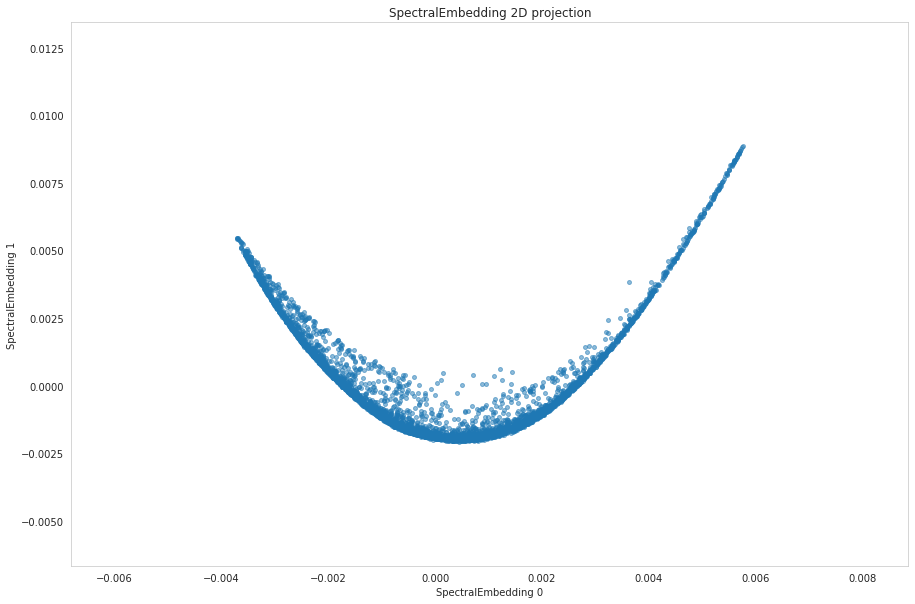

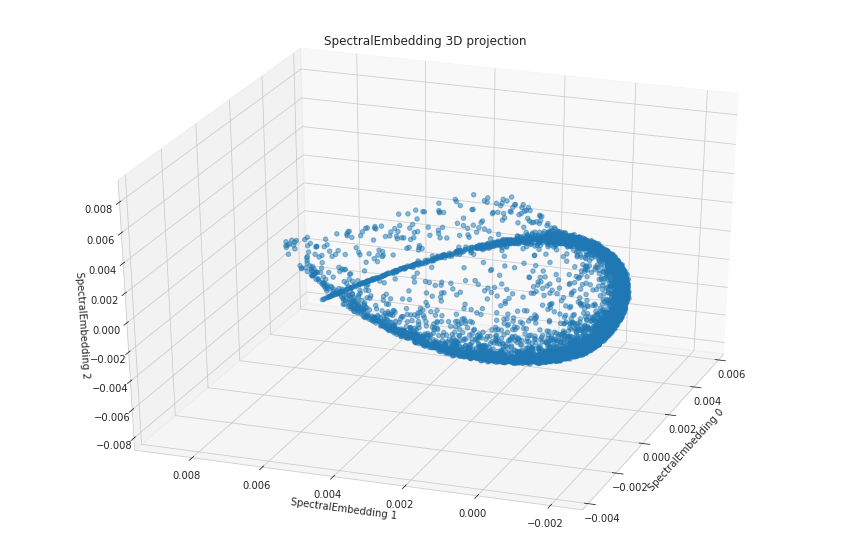

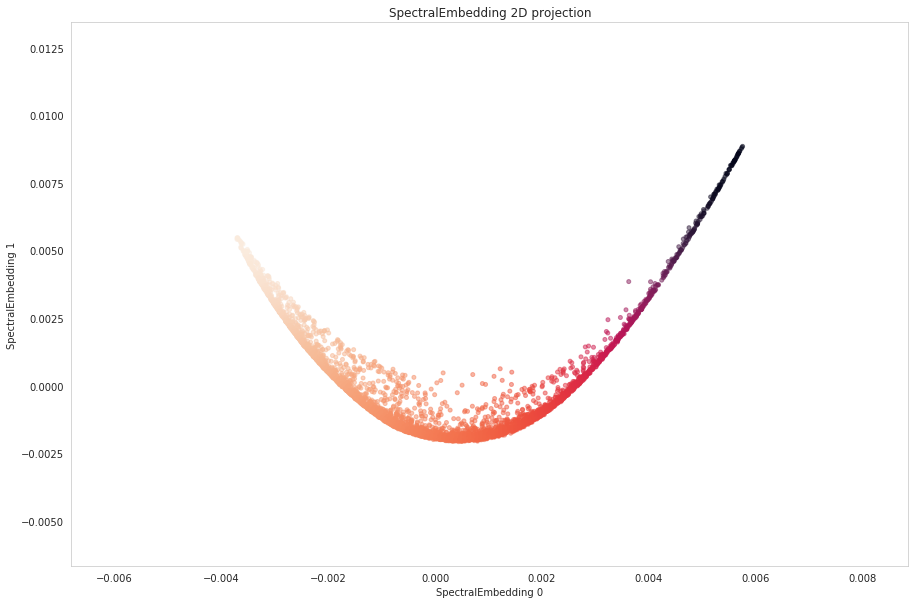

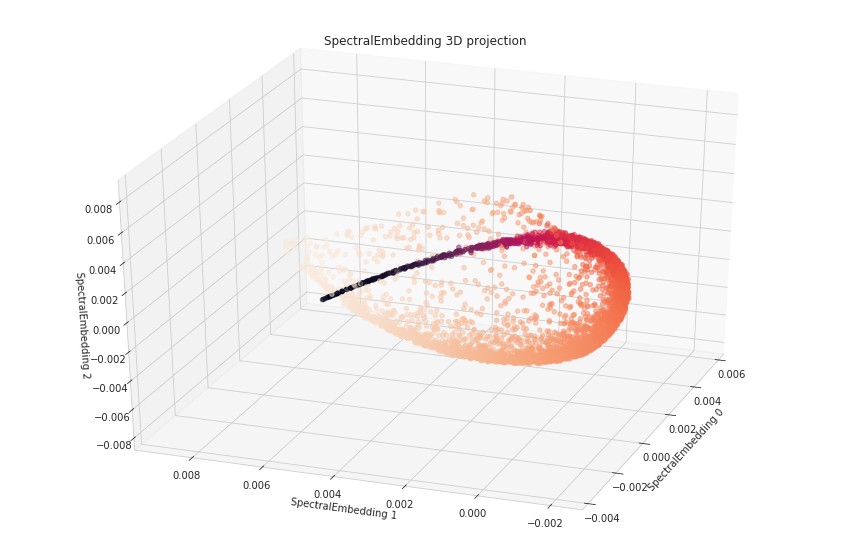

In [10]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.markersize'] = 4
almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.set_palette(almost_sequential_pal)

method = SpectralEmbedding
hyperparams_to_test = {'n_components': [14]}# np.arange(2, max_components, 2)}
method_kwargs = {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}

fig = plt.figure(figsize = (5*7*1.15, 5*(6.25 - 0.77)))
# ax0 = fig.add_subplot(spec[0])
states = ['wa', 'ga', 'tx', 'ca']#, 'wa', 'ga']#change to tx!
NUM_STATES = len(states)
NUM_COLS = 3
spec = gridspec.GridSpec(ncols=NUM_COLS, nrows=NUM_STATES, width_ratios=[1, 1.1, 1], wspace=0.00, hspace=0.15)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 2
# import matplotlib
# matplotlib.rc('font',family='Times New Roman')

for row, state in enumerate(states):
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH, INCOME_POPULATION_PATH = define_paths(state)
    print('STATE: ', state)
    analysis(state, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = True, separate = False, two_cols = False)
# fig.subplots_adjust(hspace=0.15, wspace=0.05)
plt.tight_layout()

In [16]:
fig.savefig(os.path.join(configurations['FIGURE_PATH'], 'summary_fig_three_cols_after_update.png'), bbox_inches = 'tight', dpi = 300)

### CA experiment

STATE:  wa
Data loaded. Dropped NaNs shape:(4752, 117). Initial shape:(4764, 117)
##################D-RED#################
Saving optimal embedding. Method:  SpectralEmbedding shape:  (4752, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################
fitting ...
  |======================================================================| 100%
Elbow point: 4 components with BIC 878676.9388277686
fitting ...
  |======================================================================| 100%
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VVV (ellipsoidal, varying volume, shape, and orientat

/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

##################FINAL VIZ#################
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
STATE:  ga
Data loaded. Dropped NaNs shape:(5510, 117). Initial shape:(5519, 117)
##################D-RED#################
Saving optimal embedding. Method:  SpectralEmbedding shape:  (5510, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################
fitting ...
  |======================================================================| 100%
Elbow point: 5 components with BIC 1105333.5637084302
fitting ...
  |======================================================================| 100%
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
-------

/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

##################FINAL VIZ#################
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}


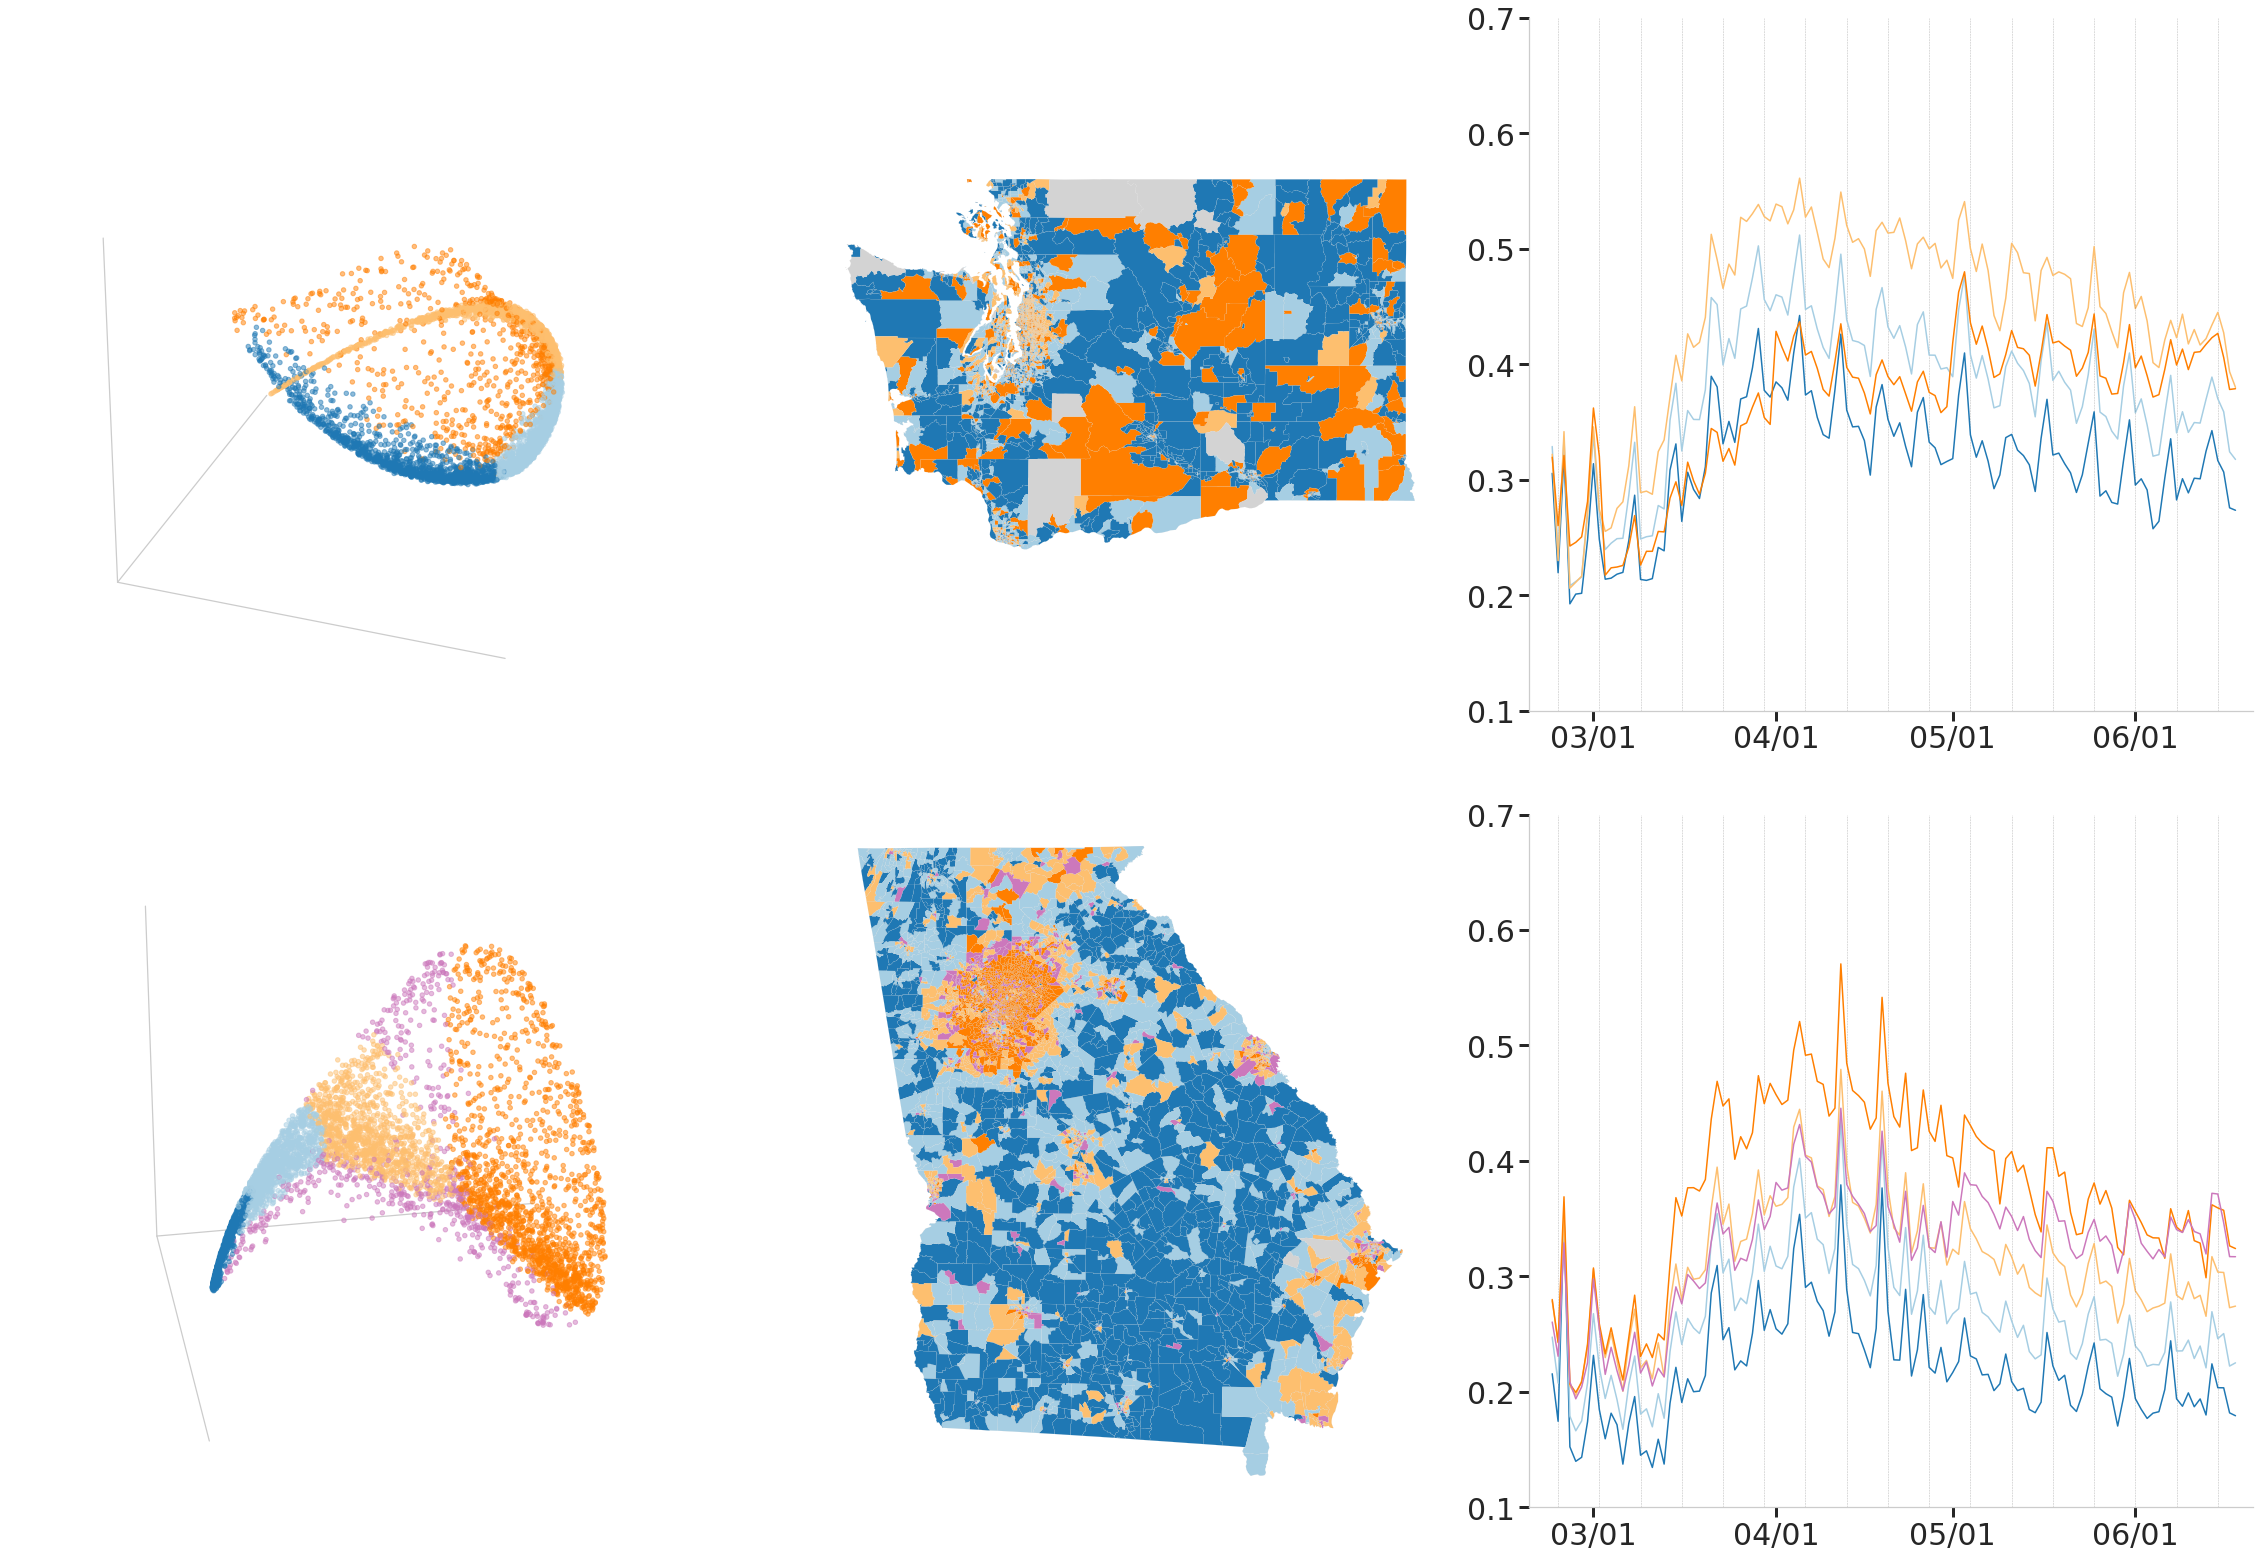

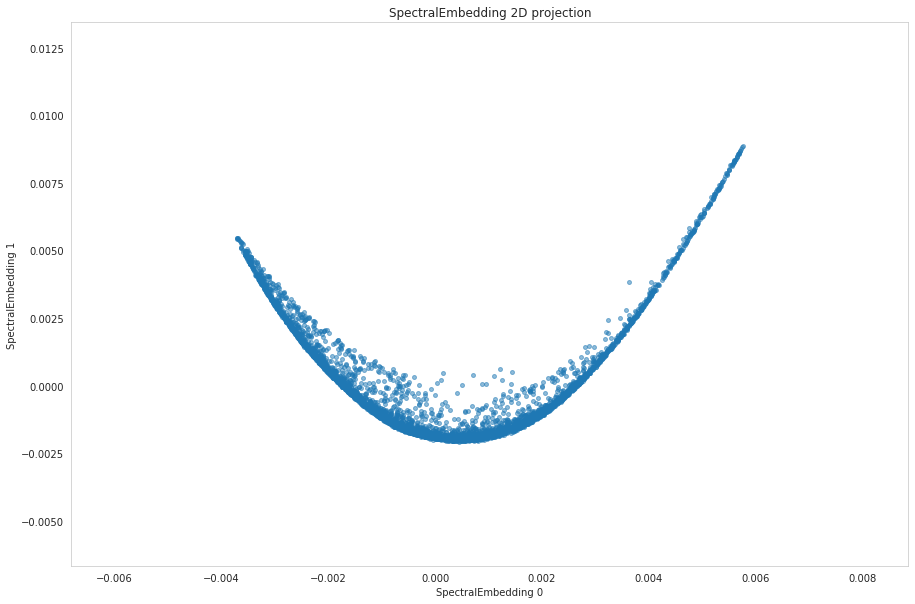

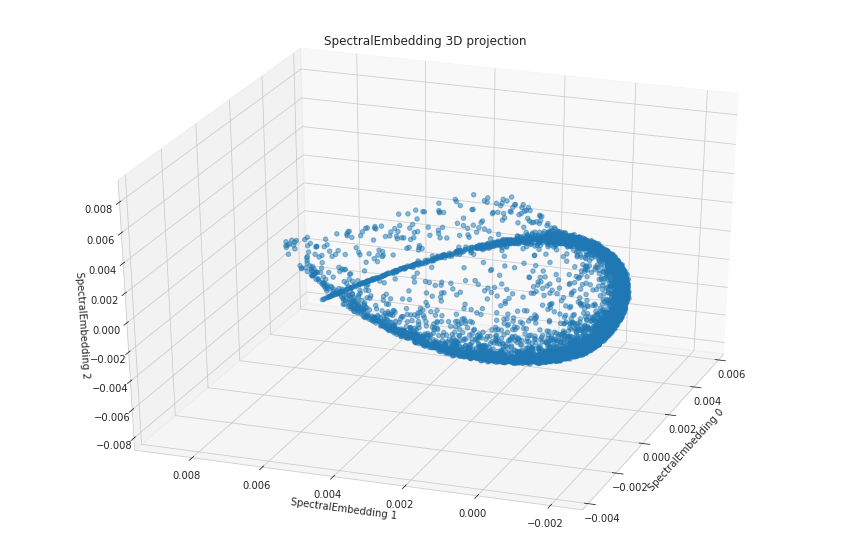

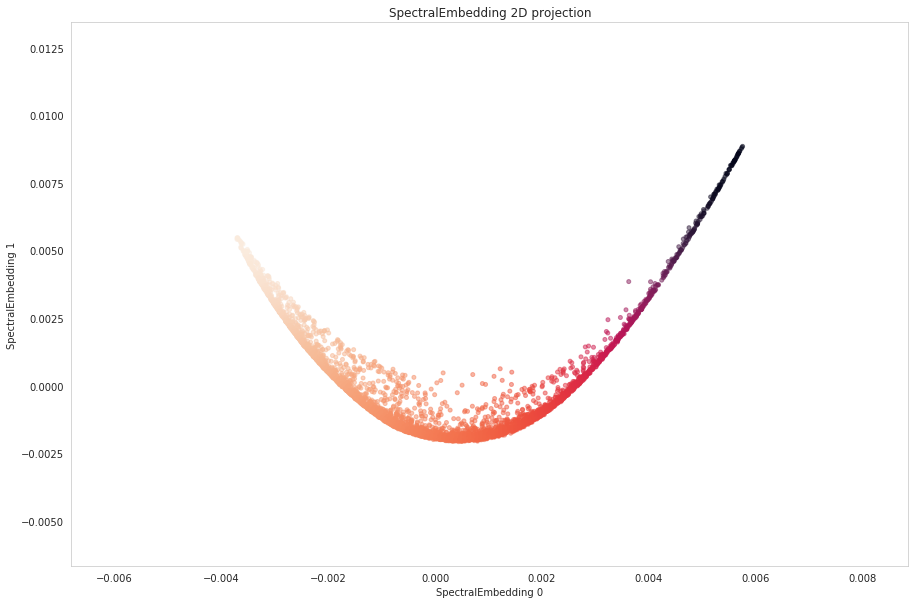

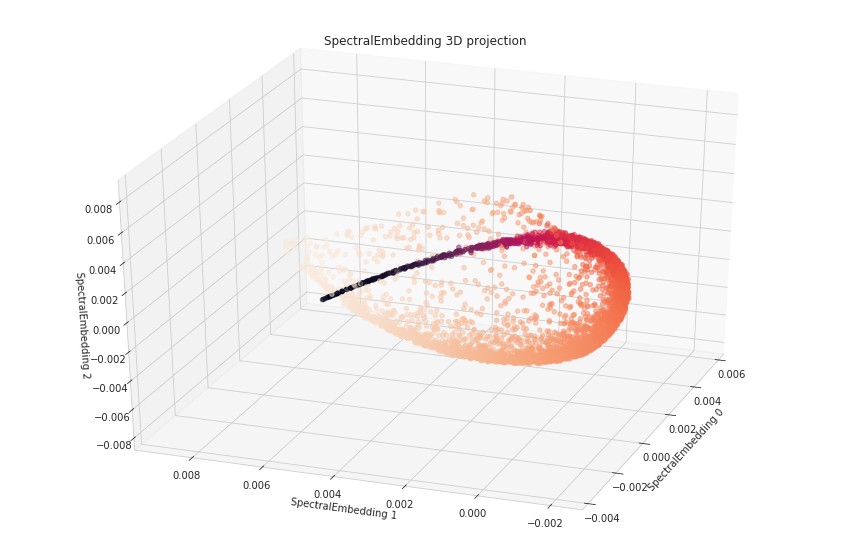

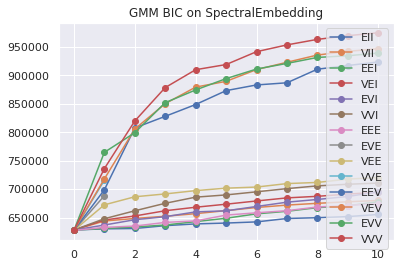

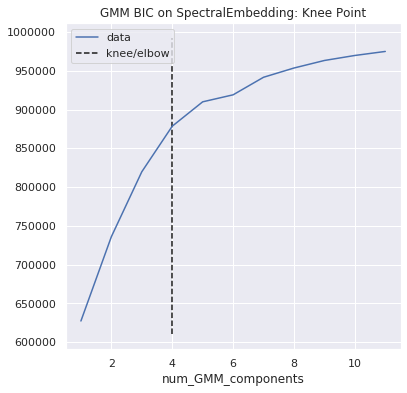

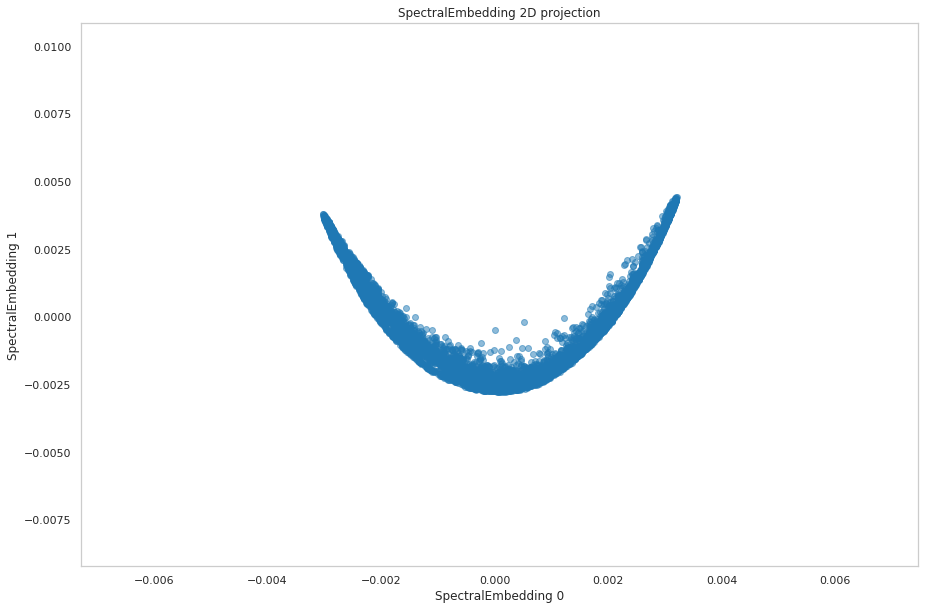

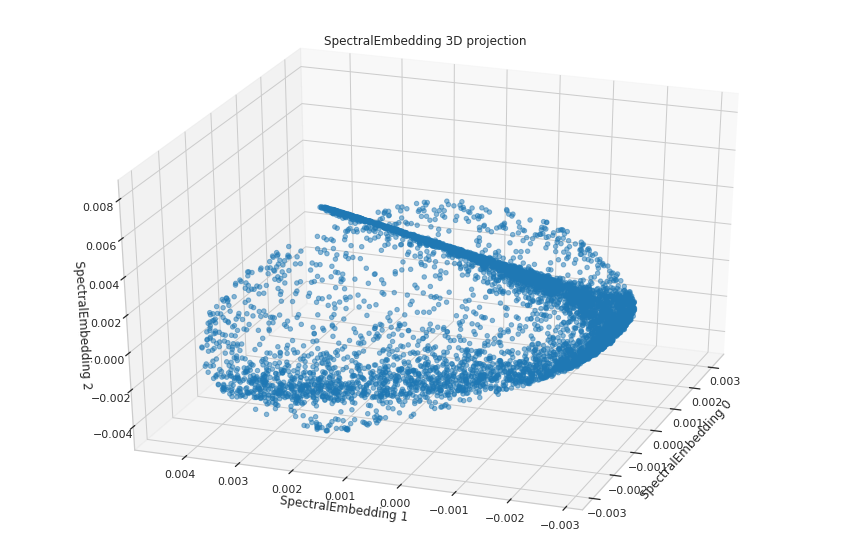

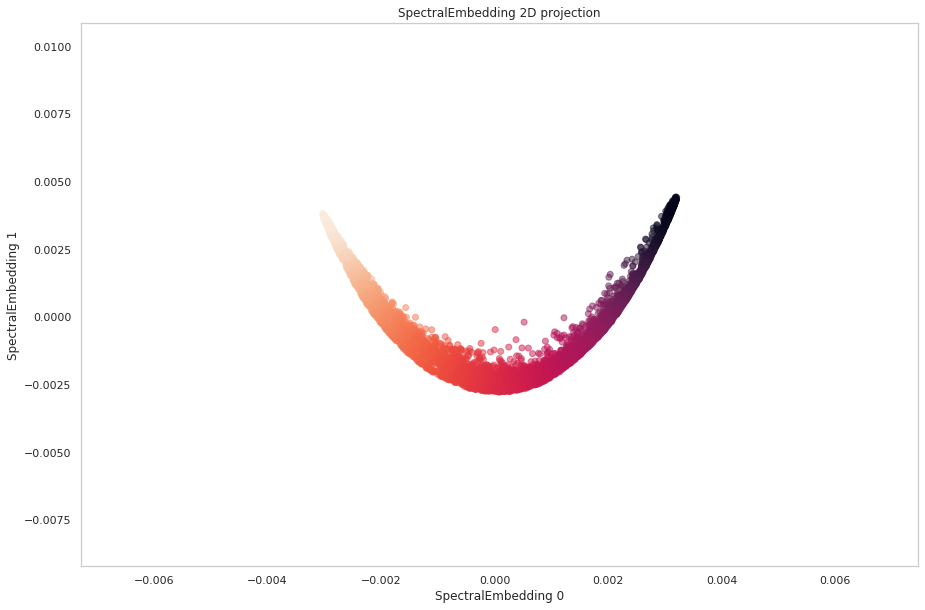

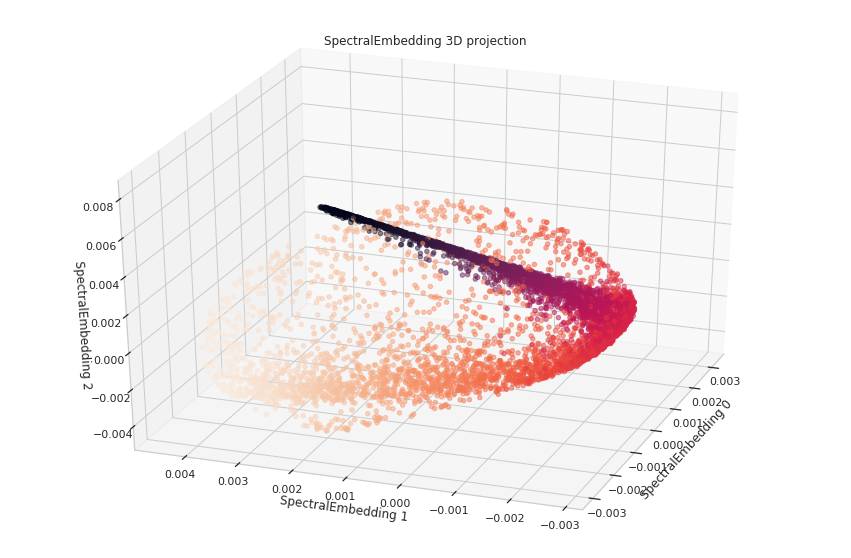

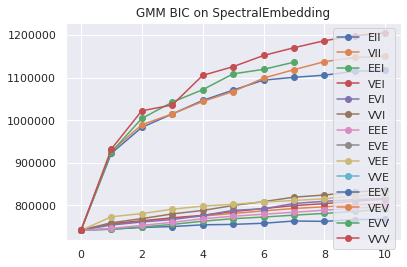

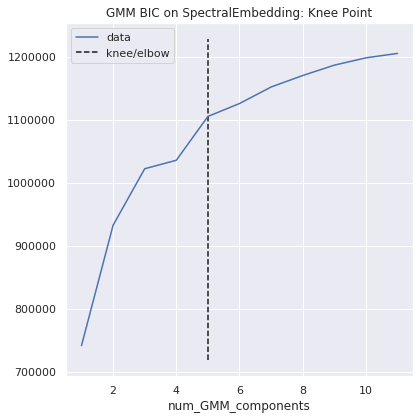

In [10]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.markersize'] = 4
almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.set_palette(almost_sequential_pal)

method = SpectralEmbedding
hyperparams_to_test = {'n_components': [14]}# np.arange(2, max_components, 2)}
method_kwargs = {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}

fig = plt.figure(figsize = (5*7*1.15, 5*(6.25 - 0.77)))
# ax0 = fig.add_subplot(spec[0])
states = ['wa', 'ga']#, 'wa', 'ga']#change to tx!
NUM_STATES = len(states)
NUM_COLS = 3
spec = gridspec.GridSpec(ncols=NUM_COLS, nrows=NUM_STATES, width_ratios=[1, 1.1, 1], wspace=0.00, hspace=0.15)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 2
# import matplotlib
# matplotlib.rc('font',family='Times New Roman')

for row, state in enumerate(states):
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH, INCOME_POPULATION_PATH = define_paths(state)
    print('STATE: ', state)
    analysis(state, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = True, separate = False, two_cols = False)
# fig.subplots_adjust(hspace=0.15, wspace=0.05)
plt.tight_layout()

In [11]:
fig.savefig(os.path.join(configurations['FIGURE_PATH'], 'summary_fig_three_cols_optimal_clust.png'), bbox_inches = 'tight', dpi = 300)

In [88]:
intersections  = 
np.array([[0.0,  0.0,  0.0,  0.0],
[0.0,  0.0,  1.0,  0.0],
[0.0,  1.0,  0.0, 2.0],
[0.0,  0.0,  2.0,  0.0]])

In [103]:
((intersections > 0).sum() > 1)

True

In [95]:
# intersections.sum(axis = 1)
int(np.squeeze(np.where((intersections > 0).sum() > 1)))+1

1

In [104]:
(intersections > 0).sum(axis = 0) > 1

array([0, 1, 2, 1])

In [11]:
print(ro.r('set.seed(0); rnorm(1)'))

[1] 1.262954



In [101]:
np.argmax((intersections > 0).sum(axis = 0))

2

In [99]:
np.where((intersections > 0).sum(axis = 0) > 1)

(array([2]),)

In [ ]:
#Experiment with optimal dimensionality of embedding, previous was the experiment with optimal cluster number
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.markersize'] = 4
almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.set_palette(almost_sequential_pal)

method = SpectralEmbedding
hyperparams_to_test = {'n_components': [10,12,14,16,18]}# np.arange(2, max_components, 2)}
method_kwargs = {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}

fig = plt.figure(figsize = (5*7*1.15, 5*(6.25 - 0.77)))
# ax0 = fig.add_subplot(spec[0])
states = ['wa', 'ga', 'tx', 'ca']#, 'wa', 'ga']#change to tx!
NUM_STATES = len(states)
NUM_COLS = 3
spec = gridspec.GridSpec(ncols=NUM_COLS, nrows=NUM_STATES, width_ratios=[1, 1.1, 1], wspace=0.00, hspace=0.15)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 2
# import matplotlib
# matplotlib.rc('font',family='Times New Roman')

for row, state in enumerate(states):
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH, INCOME_POPULATION_PATH = define_paths(state)
    print('STATE: ', state)
    analysis(state, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = False, separate = False, two_cols = False)
# fig.subplots_adjust(hspace=0.15, wspace=0.05)
plt.tight_layout()